### Group Assignent 1: Markdown strategy

Running 100,000 simulations...


Simulating: 100%|██████████| 100000/100000 [09:34<00:00, 174.15it/s]



=== SIMULATION RESULTS ===
Total simulations: 100,000

=== STRATEGY PERFORMANCE SUMMARY ===
         Strategy  Mean Gap  Median Gap  Std Dev  Min Gap  Max Gap  95th Percentile  Success Rate
         adaptive     5.805       3.713    5.742    0.066   23.922           20.049        60.820
 early_aggressive     7.744       6.345    5.352    0.149   23.922           20.048        40.881
 original_pattern     8.101       6.584    6.753    0.016   27.633           23.416        41.136
         moderate     8.457       6.362    7.397    0.097   29.769           24.973        42.436
late_conservative    10.417       6.412    9.605    0.225   35.129           29.702        42.932

=== CREATING ENHANCED VISUALIZATIONS ===


/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43941/1460288449.py:496: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(gap_data, labels=strategies)
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43941/1460288449.py:508: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_gaps = results_df.groupby(demand_bins)[gap_col].mean()


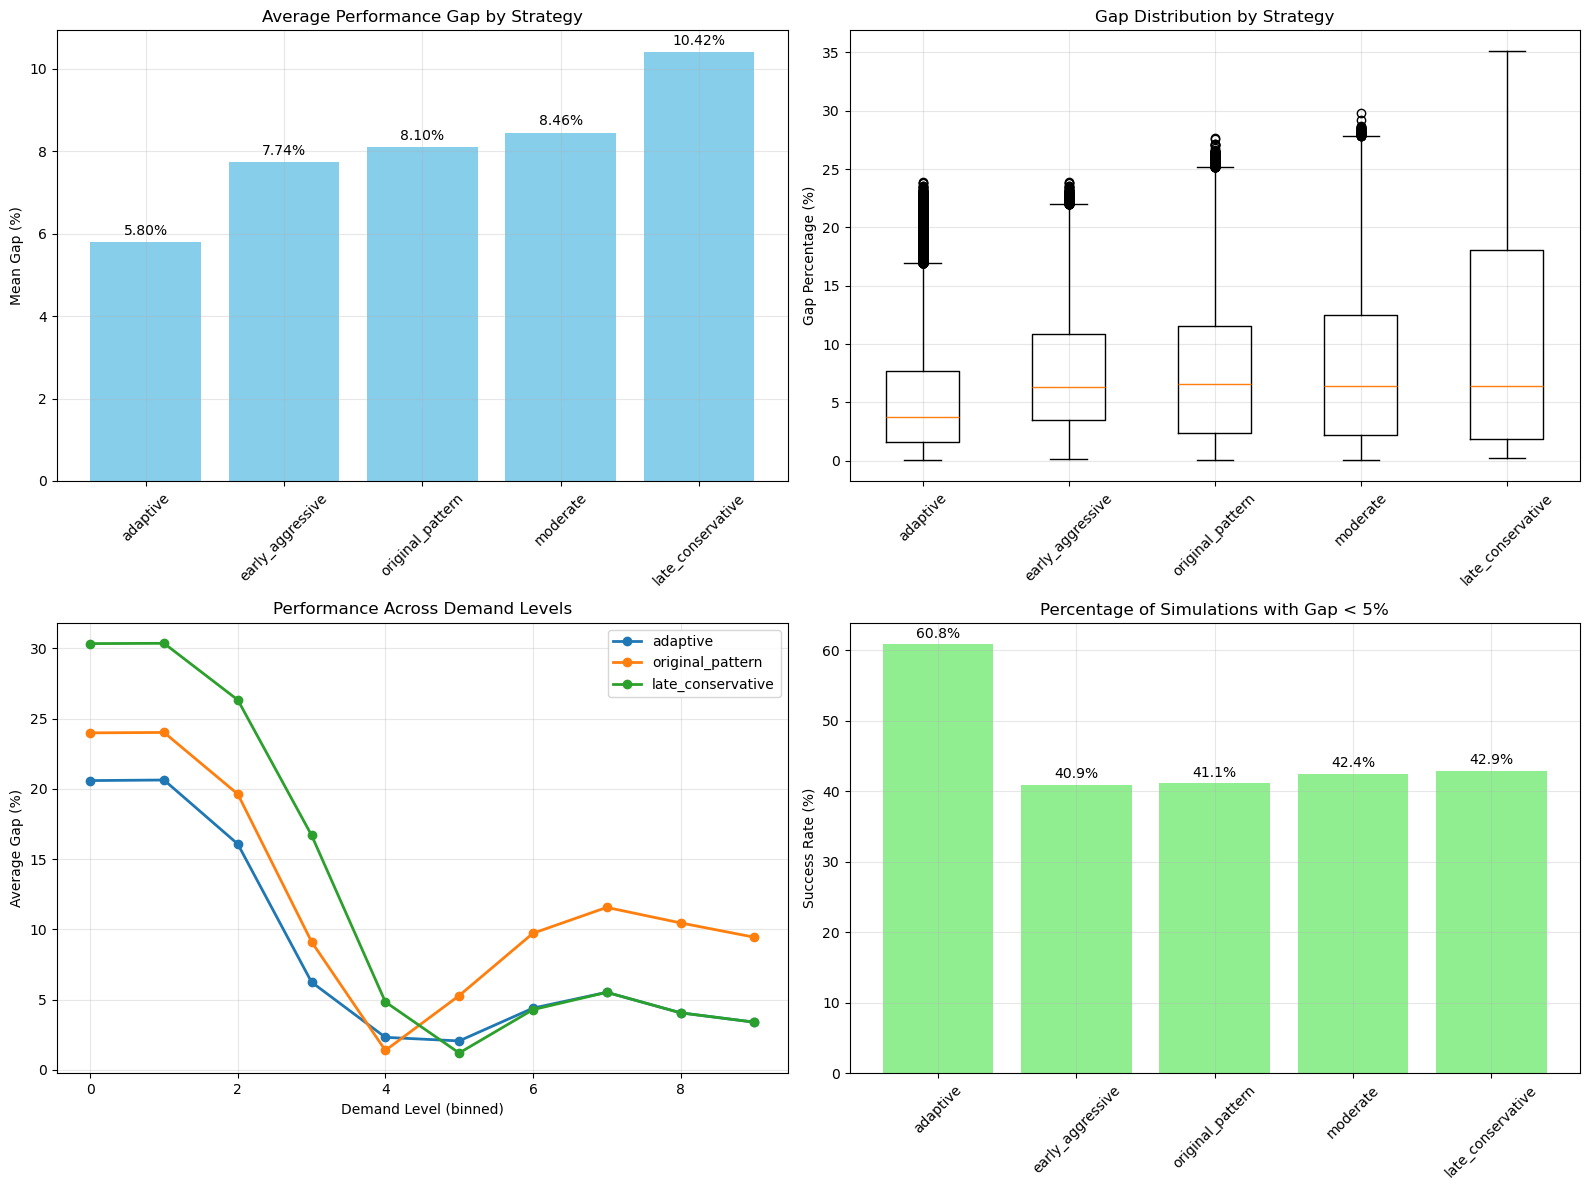


Creating Strategy Decision Tree...


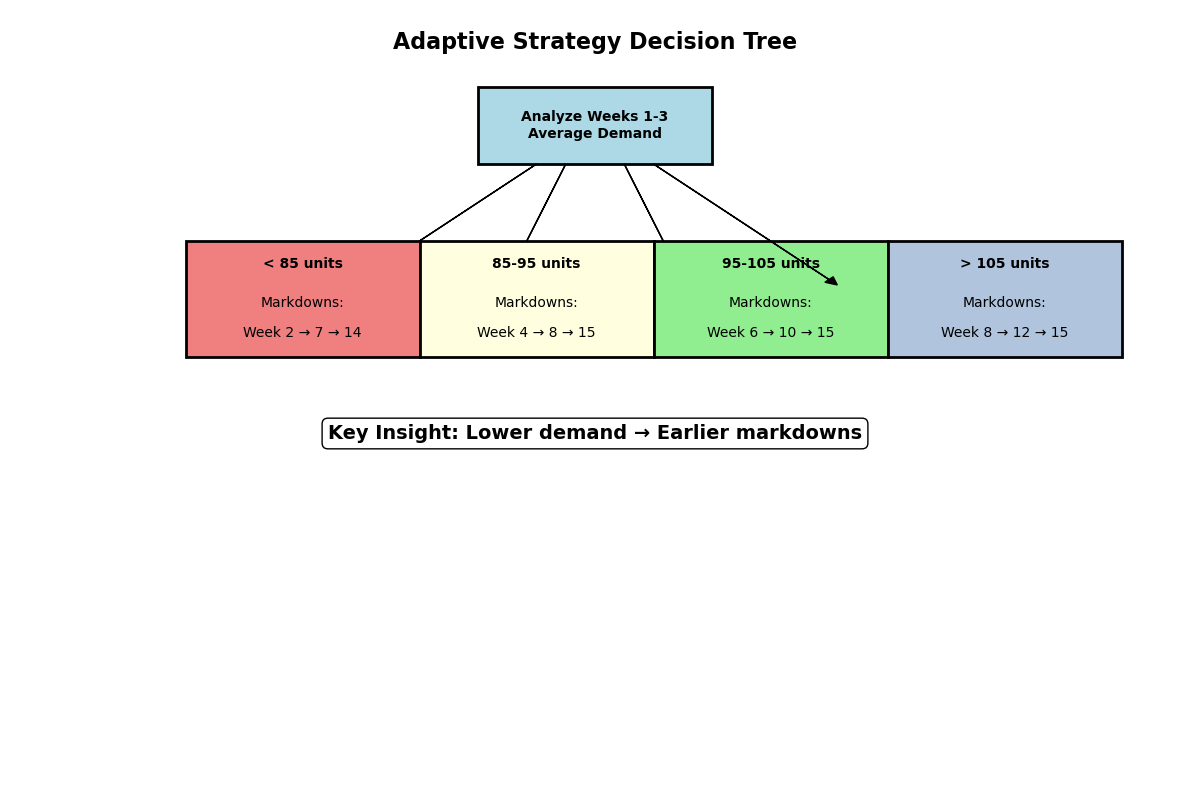

Creating Markdown Timeline Comparison...


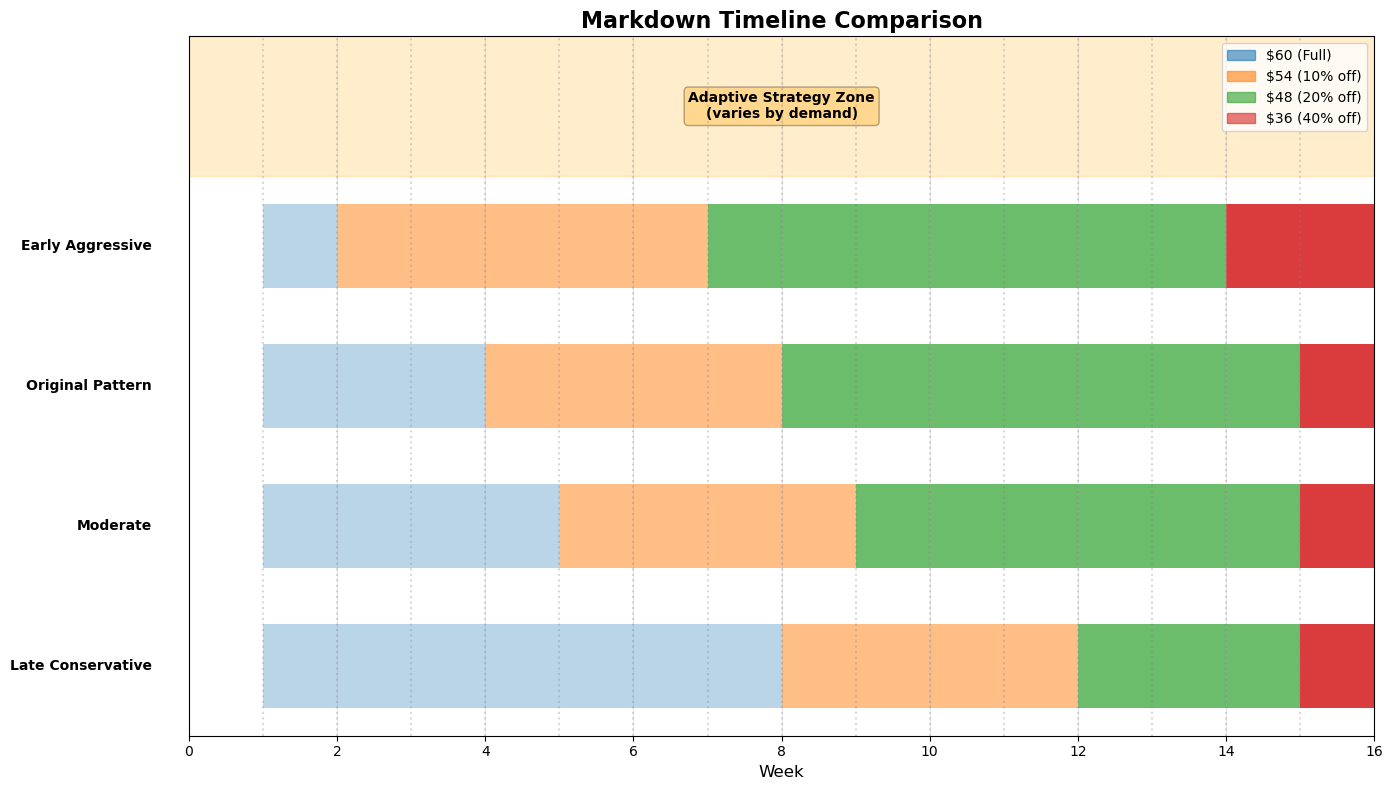

Creating Performance Heatmap...


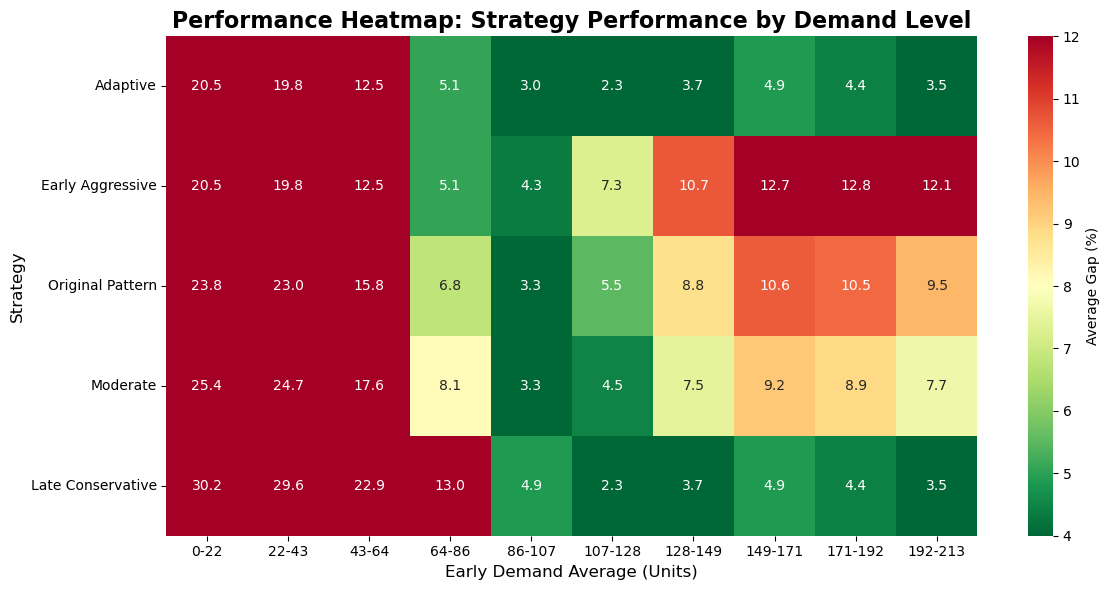

Creating Inventory Depletion Curves...


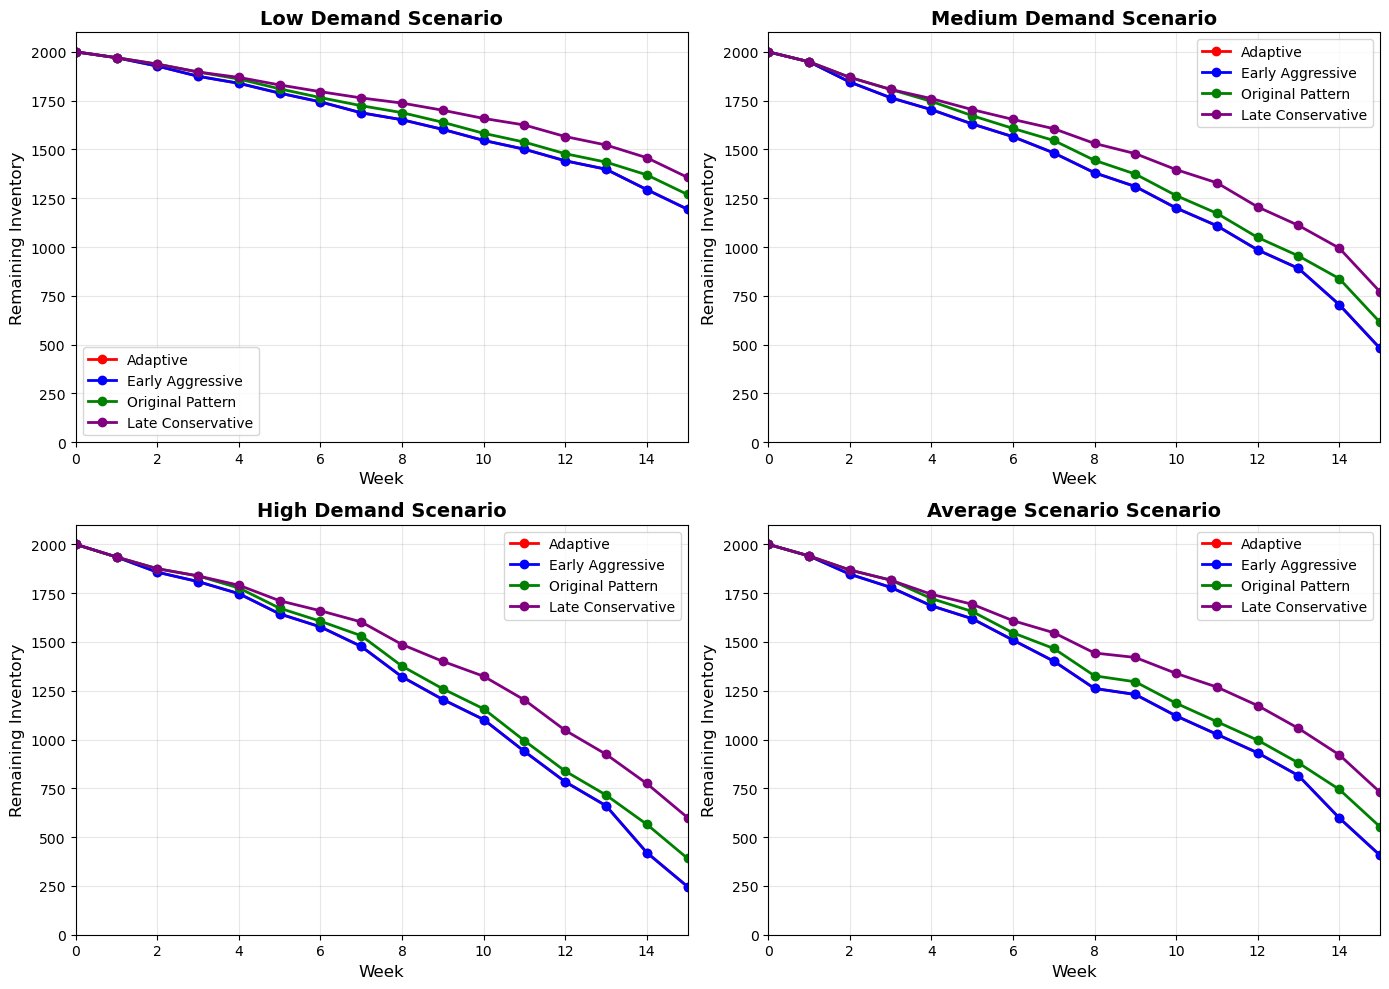

Creating Performance Dashboard...


/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43941/1460288449.py:440: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


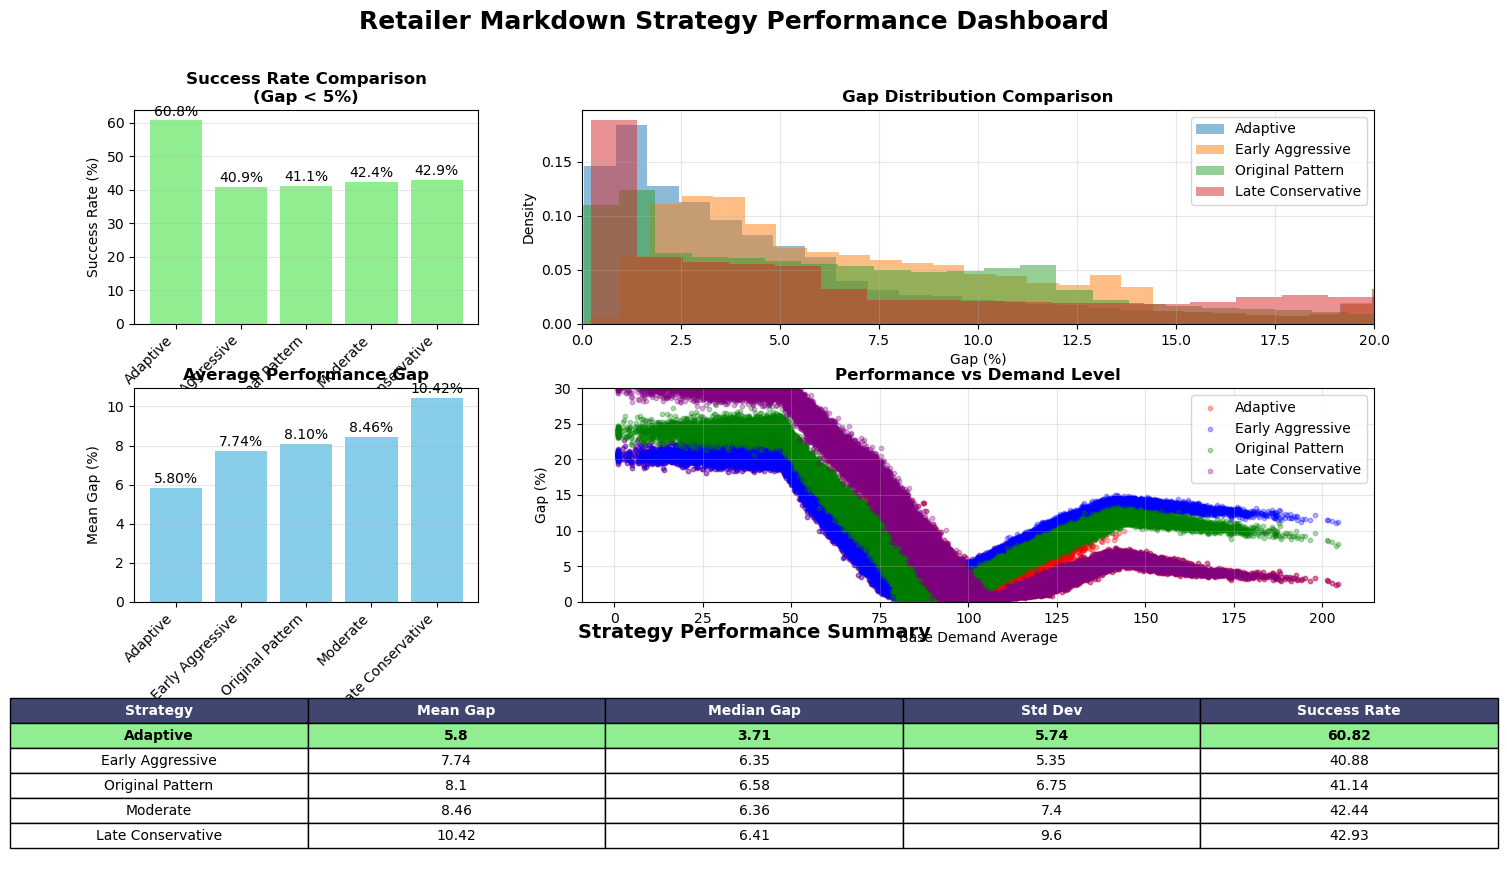


Execution time: 585.72 seconds

Results saved to:
- simulation_results_20k.csv (full results)
- summary_stats_20k.csv (summary statistics)
- simulation_results_20k.png (original visualizations)
- strategy_decision_tree.png
- markdown_timeline_comparison.png
- performance_heatmap.png
- inventory_depletion_curves.png
- performance_dashboard.png

=== KEY FINDINGS ===
1. Best performing strategy: adaptive (mean gap: 5.805%)
2. The adaptive strategy achieves 60.8% success rate
3. Early aggressive markdowns generally outperform late conservative ones

Your original strategy average gap: 6.957%
Best strategy from simulation: 5.805%


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

class RetailerSimulator:
    def __init__(self):
        self.price_levels = [60, 54, 48, 36]
        self.demand_multipliers = [1.0, 1.3, 1.75, 2.8]
        self.initial_inventory = 2000
        self.total_weeks = 15

    def generate_demand_pattern(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        initial_mean = 90
        initial_std = 0.3 * initial_mean

        base_demand = max(1, np.random.normal(initial_mean, initial_std))
        demands = [base_demand]

        for week in range(1, self.total_weeks):
            week_std = min(30, 0.3 * base_demand)
            week_demand = max(1, np.random.normal(base_demand, week_std))
            demands.append(week_demand)

        return demands

    def simulate_strategy(self, base_demands, markdown_schedule):
        inventory = self.initial_inventory
        revenue = 0
        weekly_data = []

        for week in range(1, self.total_weeks + 1):
            if inventory <= 0:
                weekly_data.append({
                    'week': week,
                    'price': 36,
                    'sales': 0,
                    'inventory': 0,
                    'revenue': 0
                })
                continue

            if week >= markdown_schedule.get('third', 16):
                price = 36
                multiplier = self.demand_multipliers[3]
            elif week >= markdown_schedule.get('second', 16):
                price = 48
                multiplier = self.demand_multipliers[2]
            elif week >= markdown_schedule.get('first', 16):
                price = 54
                multiplier = self.demand_multipliers[1]
            else:
                price = 60
                multiplier = self.demand_multipliers[0]

            demand = min(inventory, base_demands[week-1] * multiplier)

            weekly_revenue = price * demand
            revenue += weekly_revenue
            inventory -= demand

            weekly_data.append({
                'week': week,
                'price': price,
                'sales': demand,
                'inventory': inventory,
                'revenue': weekly_revenue
            })

        return revenue, weekly_data

    def calculate_perfect_revenue(self, base_demands):
        best_revenue = 0

        for first in range(1, self.total_weeks + 1):
            for second in range(first, self.total_weeks + 1):
                for third in range(second, self.total_weeks + 1):
                    schedule = {'first': first, 'second': second, 'third': third}
                    revenue, _ = self.simulate_strategy(base_demands, schedule)

                    if revenue > best_revenue:
                        best_revenue = revenue

        return best_revenue

    def get_adaptive_schedule(self, base_demands):
        early_avg = np.mean(base_demands[:3])

        if early_avg < 85:
            return {'first': 2, 'second': 7, 'third': 14}
        elif early_avg < 95:
            return {'first': 4, 'second': 8, 'third': 15}
        elif early_avg < 105:
            return {'first': 6, 'second': 10, 'third': 15}
        else:
            return {'first': 8, 'second': 12, 'third': 15}


def run_simulation(n_simulations=20000):
    simulator = RetailerSimulator()

    strategies = {
        'adaptive': None,
        'early_aggressive': {'first': 2, 'second': 7, 'third': 14},
        'original_pattern': {'first': 4, 'second': 8, 'third': 15},
        'moderate': {'first': 5, 'second': 9, 'third': 15},
        'late_conservative': {'first': 8, 'second': 12, 'third': 15}
    }

    results = []

    print(f"Running {n_simulations:,} simulations...")

    pbar = tqdm(total=n_simulations, desc="Simulating")

    for sim_id in range(n_simulations):
        seed = 42 + sim_id * 1000

        base_demands = simulator.generate_demand_pattern(seed)

        perfect_revenue = simulator.calculate_perfect_revenue(base_demands)

        sim_results = {
            'simulation': sim_id,
            'perfect_revenue': perfect_revenue,
            'base_demand_avg': np.mean(base_demands),
            'base_demand_std': np.std(base_demands),
            'early_demand_avg': np.mean(base_demands[:3])
        }

        for strategy_name, schedule in strategies.items():
            if strategy_name == 'adaptive':
                schedule = simulator.get_adaptive_schedule(base_demands)

            revenue, _ = simulator.simulate_strategy(base_demands, schedule)
            sim_results[f'{strategy_name}_revenue'] = revenue
            if perfect_revenue > 0:
                sim_results[f'{strategy_name}_gap'] = ((perfect_revenue - revenue) / perfect_revenue) * 100
            else:
                sim_results[f'{strategy_name}_gap'] = 0 if revenue == 0 else -100

        results.append(sim_results)
        pbar.update(1)

    pbar.close()

    return pd.DataFrame(results)


def create_strategy_decision_tree():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    ax.text(5, 9.5, 'Adaptive Strategy Decision Tree', fontsize=16, fontweight='bold', ha='center')

    root = Rectangle((4, 8), 2, 1, facecolor='lightblue', edgecolor='black', linewidth=2)
    ax.add_patch(root)
    ax.text(5, 8.5, 'Analyze Weeks 1-3\nAverage Demand', ha='center', va='center', fontweight='bold')

    ax.arrow(4.5, 8, -1.5, -1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    rect1 = Rectangle((1.5, 5.5), 2, 1.5, facecolor='lightcoral', edgecolor='black', linewidth=2)
    ax.add_patch(rect1)
    ax.text(2.5, 6.7, '< 85 units', ha='center', va='center', fontweight='bold')
    ax.text(2.5, 6.2, 'Markdowns:', ha='center', va='center')
    ax.text(2.5, 5.8, 'Week 2 → 7 → 14', ha='center', va='center')

    ax.arrow(4.75, 8, -0.5, -1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    rect2 = Rectangle((3.5, 5.5), 2, 1.5, facecolor='lightyellow', edgecolor='black', linewidth=2)
    ax.add_patch(rect2)
    ax.text(4.5, 6.7, '85-95 units', ha='center', va='center', fontweight='bold')
    ax.text(4.5, 6.2, 'Markdowns:', ha='center', va='center')
    ax.text(4.5, 5.8, 'Week 4 → 8 → 15', ha='center', va='center')

    ax.arrow(5.25, 8, 0.5, -1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    rect3 = Rectangle((5.5, 5.5), 2, 1.5, facecolor='lightgreen', edgecolor='black', linewidth=2)
    ax.add_patch(rect3)
    ax.text(6.5, 6.7, '95-105 units', ha='center', va='center', fontweight='bold')
    ax.text(6.5, 6.2, 'Markdowns:', ha='center', va='center')
    ax.text(6.5, 5.8, 'Week 6 → 10 → 15', ha='center', va='center')

    ax.arrow(5.5, 8, 1.5, -1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    rect4 = Rectangle((7.5, 5.5), 2, 1.5, facecolor='lightsteelblue', edgecolor='black', linewidth=2)
    ax.add_patch(rect4)
    ax.text(8.5, 6.7, '> 105 units', ha='center', va='center', fontweight='bold')
    ax.text(8.5, 6.2, 'Markdowns:', ha='center', va='center')
    ax.text(8.5, 5.8, 'Week 8 → 12 → 15', ha='center', va='center')

    ax.text(5, 4.5, 'Key Insight: Lower demand → Earlier markdowns',
            ha='center', va='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))

    plt.tight_layout()
    plt.savefig('strategy_decision_tree.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_markdown_timeline_comparison(strategies):
    fig, ax = plt.subplots(figsize=(14, 8))

    strategy_names = ['early_aggressive', 'original_pattern', 'moderate', 'late_conservative']
    strategy_colors = ['red', 'blue', 'green', 'purple']
    y_positions = [3, 2, 1, 0]

    # Define colors corresponding to price levels
    price_colors = {
        60: '#1f77b4',  # Example blue for $60
        54: '#ff7f0e',  # Example orange for $54
        48: '#2ca02c',  # Example green for $48
        36: '#d62728'   # Example red for $36
    }

    for i, (strategy_name, strategy_color, y_pos) in enumerate(zip(strategy_names, strategy_colors, y_positions)):
        schedule = strategies[strategy_name]

        ax.barh(y_pos, schedule['first']-1, left=1, height=0.6,
                color=price_colors[60], alpha=0.3, label=f'{strategy_name} - $60' if i == 0 else "")

        ax.barh(y_pos, schedule['second']-schedule['first'], left=schedule['first'], height=0.6,
                color=price_colors[54], alpha=0.5, label=f'{strategy_name} - $54' if i == 0 else "")

        ax.barh(y_pos, schedule['third']-schedule['second'], left=schedule['second'], height=0.6,
                color=price_colors[48], alpha=0.7, label=f'{strategy_name} - $48' if i == 0 else "")

        ax.barh(y_pos, 16-schedule['third'], left=schedule['third'], height=0.6,
                color=price_colors[36], alpha=0.9, label=f'{strategy_name} - $36' if i == 0 else "")

        ax.text(-0.5, y_pos, strategy_name.replace('_', ' ').title(),
                ha='right', va='center', fontweight='bold')

    ax.axhspan(3.5, 4.5, xmin=0, xmax=1, alpha=0.2, color='orange')
    ax.text(8, 4, 'Adaptive Strategy Zone\n(varies by demand)',
            ha='center', va='center', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.3))

    ax.set_xlim(0, 16)
    ax.set_ylim(-0.5, 4.5)
    ax.set_xlabel('Week', fontsize=12)
    ax.set_title('Markdown Timeline Comparison', fontsize=16, fontweight='bold')
    ax.set_yticks([])
    ax.grid(True, axis='x', alpha=0.3)

    for week in range(1, 16):
        ax.axvline(week, color='gray', alpha=0.3, linestyle=':')

    # Create legend handles based on price colors
    legend_handles = [
        mpatches.Patch(color=price_colors[60], alpha=0.6, label='$60 (Full)'),
        mpatches.Patch(color=price_colors[54], alpha=0.6, label='$54 (10% off)'),
        mpatches.Patch(color=price_colors[48], alpha=0.6, label='$48 (20% off)'),
        mpatches.Patch(color=price_colors[36], alpha=0.6, label='$36 (40% off)')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()
    plt.savefig('markdown_timeline_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_performance_heatmap(results_df):
    demand_bins = pd.cut(results_df['early_demand_avg'], bins=10)

    strategies = ['adaptive', 'early_aggressive', 'original_pattern', 'moderate', 'late_conservative']
    heatmap_data = []

    for strategy in strategies:
        row = []
        for bin_val in demand_bins.cat.categories:
            mask = demand_bins == bin_val
            avg_gap = results_df.loc[mask, f'{strategy}_gap'].mean()
            row.append(avg_gap)
        heatmap_data.append(row)

    fig, ax = plt.subplots(figsize=(12, 6))

    heatmap_df = pd.DataFrame(heatmap_data,
                              index=[s.replace('_', ' ').title() for s in strategies],
                              columns=[f'{int(b.left)}-{int(b.right)}' for b in demand_bins.cat.categories])

    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn_r',
                center=8, vmin=4, vmax=12, ax=ax, cbar_kws={'label': 'Average Gap (%)'})

    ax.set_xlabel('Early Demand Average (Units)', fontsize=12)
    ax.set_ylabel('Strategy', fontsize=12)
    ax.set_title('Performance Heatmap: Strategy Performance by Demand Level', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('performance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_inventory_depletion_curves(simulator):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    scenarios = [
        {'name': 'Low Demand', 'seed': 100, 'demand_level': 'low'},
        {'name': 'Medium Demand', 'seed': 200, 'demand_level': 'medium'},
        {'name': 'High Demand', 'seed': 300, 'demand_level': 'high'},
        {'name': 'Average Scenario', 'seed': 400, 'demand_level': 'average'}
    ]

    strategies = {
        'adaptive': None,
        'early_aggressive': {'first': 2, 'second': 7, 'third': 14},
        'original_pattern': {'first': 4, 'second': 8, 'third': 15},
        'late_conservative': {'first': 8, 'second': 12, 'third': 15}
    }

    colors = ['red', 'blue', 'green', 'purple']

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]

        base_demands = simulator.generate_demand_pattern(scenario['seed'])

        if scenario['demand_level'] == 'low':
            base_demands = [d * 0.7 for d in base_demands]
        elif scenario['demand_level'] == 'high':
            base_demands = [d * 1.3 for d in base_demands]

        for strategy_name, schedule, color in zip(strategies.keys(), strategies.values(), colors):
            if strategy_name == 'adaptive':
                schedule = simulator.get_adaptive_schedule(base_demands)

            _, weekly_data = simulator.simulate_strategy(base_demands, schedule)

            weeks = [0] + [w['week'] for w in weekly_data]
            inventory = [simulator.initial_inventory] + [w['inventory'] for w in weekly_data]

            ax.plot(weeks, inventory, label=strategy_name.replace('_', ' ').title(),
                    color=color, linewidth=2, marker='o', markersize=6)

        ax.set_xlabel('Week', fontsize=12)
        ax.set_ylabel('Remaining Inventory', fontsize=12)
        ax.set_title(f'{scenario["name"]} Scenario', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 2100)

    plt.tight_layout()
    plt.savefig('inventory_depletion_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_performance_dashboard(results_df, summary_df):
    fig = plt.figure(figsize=(16, 10))

    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    success_rates = summary_df['Success Rate'].values
    strategies = summary_df['Strategy'].values
    bars = ax1.bar(range(len(strategies)), success_rates, color='lightgreen')
    ax1.set_xticks(range(len(strategies)))
    ax1.set_xticklabels([s.replace('_', ' ').title() for s in strategies], rotation=45, ha='right')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Success Rate Comparison\n(Gap < 5%)', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

    for bar, value in zip(bars, success_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{value:.1f}%', ha='center', va='bottom')

    ax2 = fig.add_subplot(gs[0, 1:])
    strategies_to_plot = ['adaptive', 'early_aggressive', 'original_pattern', 'late_conservative']
    for strategy in strategies_to_plot:
        gap_data = results_df[f'{strategy}_gap']
        ax2.hist(gap_data, bins=30, alpha=0.5, label=strategy.replace('_', ' ').title(),
                 density=True)
    ax2.set_xlabel('Gap (%)')
    ax2.set_ylabel('Density')
    ax2.set_title('Gap Distribution Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 20)

    ax3 = fig.add_subplot(gs[1, 0])
    mean_gaps = summary_df['Mean Gap'].values
    bars = ax3.bar(range(len(strategies)), mean_gaps, color='skyblue')
    ax3.set_xticks(range(len(strategies)))
    ax3.set_xticklabels([s.replace('_', ' ').title() for s in strategies], rotation=45, ha='right')
    ax3.set_ylabel('Mean Gap (%)')
    ax3.set_title('Average Performance Gap', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    for bar, value in zip(bars, mean_gaps):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{value:.2f}%', ha='center', va='bottom')

    ax4 = fig.add_subplot(gs[1, 1:])
    colors = ['red', 'blue', 'green', 'purple']
    for strategy, color in zip(['adaptive', 'early_aggressive', 'original_pattern', 'late_conservative'], colors):
        ax4.scatter(results_df['base_demand_avg'], results_df[f'{strategy}_gap'],
                    alpha=0.3, s=10, label=strategy.replace('_', ' ').title(), color=color)
    ax4.set_xlabel('Base Demand Average')
    ax4.set_ylabel('Gap (%)')
    ax4.set_title('Performance vs Demand Level', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 30)

    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('tight')
    ax5.axis('off')

    table_data = summary_df[['Strategy', 'Mean Gap', 'Median Gap', 'Std Dev', 'Success Rate']].copy()
    table_data['Strategy'] = table_data['Strategy'].apply(lambda x: x.replace('_', ' ').title())
    table_data = table_data.round(2)

    table = ax5.table(cellText=table_data.values,
                      colLabels=table_data.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    for i in range(len(table_data.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    best_idx = table_data['Mean Gap'].idxmin() + 1
    for j in range(len(table_data.columns)):
        table[(best_idx, j)].set_facecolor('#90ee90')
        table[(best_idx, j)].set_text_props(weight='bold')

    ax5.set_title('Strategy Performance Summary', fontweight='bold', pad=20, fontsize=14)

    plt.suptitle('Retailer Markdown Strategy Performance Dashboard', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()


def analyze_results(results_df):
    print("\n=== SIMULATION RESULTS ===")
    print(f"Total simulations: {len(results_df):,}")

    strategies = ['adaptive', 'early_aggressive', 'original_pattern', 'moderate', 'late_conservative']

    summary_data = []

    for strategy in strategies:
        gap_col = f'{strategy}_gap'

        stats = {
            'Strategy': strategy,
            'Mean Gap': results_df[gap_col].mean(),
            'Median Gap': results_df[gap_col].median(),
            'Std Dev': results_df[gap_col].std(),
            'Min Gap': results_df[gap_col].min(),
            'Max Gap': results_df[gap_col].max(),
            '95th Percentile': results_df[gap_col].quantile(0.95),
            'Success Rate': (results_df[gap_col] < 5).mean() * 100
        }
        summary_data.append(stats)

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Mean Gap')

    print("\n=== STRATEGY PERFORMANCE SUMMARY ===")
    print(summary_df.to_string(index=False, float_format='%.3f'))

    print("\n=== CREATING ENHANCED VISUALIZATIONS ===")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax = axes[0, 0]
    strategies_sorted = summary_df['Strategy'].values
    mean_gaps = summary_df['Mean Gap'].values

    bars = ax.bar(range(len(strategies_sorted)), mean_gaps, color='skyblue')
    ax.set_xticks(range(len(strategies_sorted)))
    ax.set_xticklabels(strategies_sorted, rotation=45)
    ax.set_ylabel('Mean Gap (%)')
    ax.set_title('Average Performance Gap by Strategy')
    ax.grid(True, alpha=0.3)

    for bar, value in zip(bars, mean_gaps):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value:.2f}%', ha='center', va='bottom')

    ax = axes[0, 1]
    gap_data = [results_df[f'{s}_gap'].values for s in strategies]

    ax.boxplot(gap_data, labels=strategies)
    ax.set_xticklabels(strategies, rotation=45)
    ax.set_ylabel('Gap Percentage (%)')
    ax.set_title('Gap Distribution by Strategy')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]

    for strategy in ['adaptive', 'original_pattern', 'late_conservative']:
        gap_col = f'{strategy}_gap'

        demand_bins = pd.cut(results_df['base_demand_avg'], bins=10)
        binned_gaps = results_df.groupby(demand_bins)[gap_col].mean()

        ax.plot(range(len(binned_gaps)), binned_gaps.values,
                marker='o', label=strategy, linewidth=2)

    ax.set_xlabel('Demand Level (binned)')
    ax.set_ylabel('Average Gap (%)')
    ax.set_title('Performance Across Demand Levels')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    success_rates = summary_df['Success Rate'].values

    bars = ax.bar(range(len(strategies_sorted)), success_rates, color='lightgreen')
    ax.set_xticks(range(len(strategies_sorted)))
    ax.set_xticklabels(strategies_sorted, rotation=45)
    ax.set_ylabel('Success Rate (%)')
    ax.set_title('Percentage of Simulations with Gap < 5%')
    ax.grid(True, alpha=0.3)

    for bar, value in zip(bars, success_rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('simulation_results_20k.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nCreating Strategy Decision Tree...")
    create_strategy_decision_tree()

    print("Creating Markdown Timeline Comparison...")
    strategies_dict = {
        'early_aggressive': {'first': 2, 'second': 7, 'third': 14},
        'original_pattern': {'first': 4, 'second': 8, 'third': 15},
        'moderate': {'first': 5, 'second': 9, 'third': 15},
        'late_conservative': {'first': 8, 'second': 12, 'third': 15}
    }
    create_markdown_timeline_comparison(strategies_dict)

    print("Creating Performance Heatmap...")
    create_performance_heatmap(results_df)

    print("Creating Inventory Depletion Curves...")
    simulator = RetailerSimulator()
    create_inventory_depletion_curves(simulator)

    print("Creating Performance Dashboard...")
    create_performance_dashboard(results_df, summary_df)

    return summary_df


def main():
    start_time = time.time()

    results_df = run_simulation(n_simulations=100000)

    summary_df = analyze_results(results_df)

    results_df.to_csv('simulation_results_20k.csv', index=False)
    summary_df.to_csv('summary_stats_20k.csv', index=False)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"\nExecution time: {execution_time:.2f} seconds")
    print("\nResults saved to:")
    print("- simulation_results_20k.csv (full results)")
    print("- summary_stats_20k.csv (summary statistics)")
    print("- simulation_results_20k.png (original visualizations)")
    print("- strategy_decision_tree.png")
    print("- markdown_timeline_comparison.png")
    print("- performance_heatmap.png")
    print("- inventory_depletion_curves.png")
    print("- performance_dashboard.png")

    print("\n=== KEY FINDINGS ===")
    best_strategy = summary_df.iloc[0]['Strategy']
    best_gap = summary_df.iloc[0]['Mean Gap']

    print(f"1. Best performing strategy: {best_strategy} (mean gap: {best_gap:.3f}%)")
    print(f"2. The adaptive strategy achieves {summary_df[summary_df['Strategy']=='adaptive']['Success Rate'].values[0]:.1f}% success rate")
    print(f"3. Early aggressive markdowns generally outperform late conservative ones")

    print(f"\nYour original strategy average gap: 6.957%")
    print(f"Best strategy from simulation: {best_gap:.3f}%")


if __name__ == "__main__":
    main()